In [13]:
%matplotlib inline
from matplotlib import pyplot
import geopandas as gpd
import pandas as pd
import numpy as np

from weavingspace import TileUnit
from weavingspace import Tiling
from weavingspace import tiling_utils

import shapely.geometry as geom
import shapely.affinity as affine

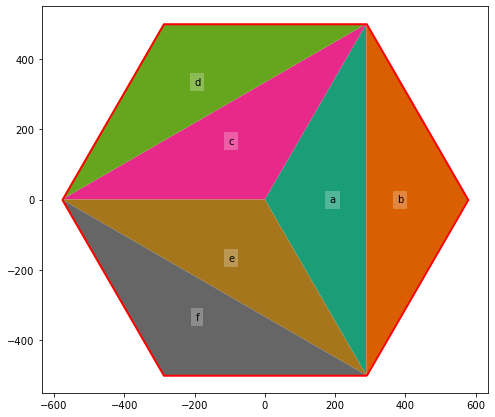

In [2]:
t = TileUnit(tiling_type = "laves", n = 6, code = "3.12.12")
t.plot()

<AxesSubplot:>

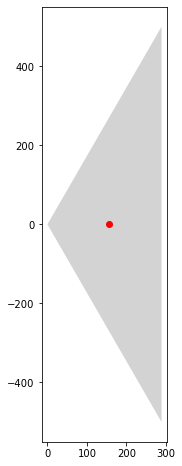

In [9]:
p = t.elements.geometry[0]
pt = tiling_utils.incentre(p)
ax = gpd.GeoSeries([p]).plot(fc = "lightgrey", figsize = (8, 8))
gpd.GeoSeries([pt]).plot(ax = ax, color = "r")

In [48]:
region = gpd.read_file("data/imd-auckland-2018.gpkg")
tile = TileUnit(tiling_type = "laves", code = "3.3.3.3.6", crs = region.crs)

In [136]:
from dataclasses import dataclass
import itertools

@dataclass
class TileGrid2():
    points:list[geom.Point] = None
    tile:TileUnit = None
    region:gpd.GeoSeries = None
    extent:gpd.GeoSeries = None
    centre:geom.Point = None
    transform:tuple[float] = None
    inverse_transform:tuple[float] = None
    
    def __init__(self, tile:TileUnit, to_tile:gpd.GeoSeries):
        self.tile = tile
        self.to_tile = tiling_utils.clean_polygon(
            gpd.GeoSeries([to_tile.unary_union]))
        self.extent, self.centre = self._get_extent()
        self.transform, self.inverse_transform = self.get_transforms()
      
    def _get_extent(self) -> tuple[gpd.GeoSeries, geom.Point]:
        """Returns the extent and centre of the grid.

        Returns:
            tuple[gpd.GeoSeries, geom.Point]: the extent of the grid and its 
                centre.
        """
        mrr = self.to_tile[0].minimum_rotated_rectangle
        mrr_centre = geom.Point(mrr.centroid.coords[0])
        mrr_corner = geom.Point(mrr.exterior.coords[0])
        radius = mrr_centre.distance(mrr_corner)
        return gpd.GeoSeries([mrr_centre.buffer(radius)]), mrr_centre
    
    def get_transforms(self) -> tuple[float]:
        v = self.tile.get_vectors()
        tfm = np.array([v[0][0], v[1][0]],
                       [v[0][1], v[1][1]]).reshape((2, 2))
        invtfm = np.linalg.inv(tfm)
        return (self._np_to_shapely_transform(tfm), 
                self._np_to_shapely_transform(invtfm))
    
    def _np_to_shapely_transform(self, mat) -> tuple[float]:
        return (mat[0][0], mat[1][0], 0, mat[0][1], mat[1][1], 0)
    
    def _shapely_transform_to_np(self, mat) -> np.ndarray:
        return np.array(mat).reshape((2, 3))[:, :2]
    
    def _get_to_tile_transformed(self) -> gpd.GeoSeries:
        return self.to_tile.affine_transform(self.transform)
    
    def get_grid(self) -> gpd.GeoSeries:
        pass

In [137]:
tg = TileGrid2(tile, region.geometry)

<AxesSubplot:>

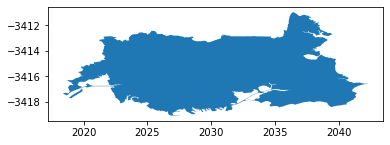

In [138]:
tg._get_to_tile_transformed().plot()

<AxesSubplot:>

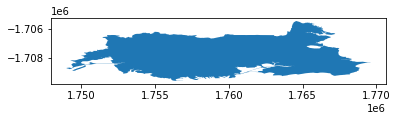

In [121]:
tg._get_to_tile_transformed().affine_transform(tg.inverse_transform).plot()

In [132]:
tg.tile.get_vectors(), tg.inverse_transform

([(866.0254037844386, 499.9999999999999),
  (6.123233995736766e-14, 1000.0),
  (-866.0254037844386, 499.9999999999999),
  (-866.0254037844387, -499.9999999999997),
  (-1.8369701987210297e-13, -1000.0),
  (866.0254037844383, -500.00000000000034)],
 (866.0254037844386, 499.9999999999999, 0, 6.123233995736766e-14, 1000.0, 0))